## FINE GAIN CALIBRATION NOTEBOOK. not meant for customer evaluation

In [1]:
#some imports
import time
from PIL import Image
import numpy as np
import pandas as pd
import pathlib
from picamera2 import Picamera2, Preview
import pprint
from ipywidgets import interact, interactive
from IPython.display import display
import matplotlib.pyplot as plt
import sys
sys.path.append("../common")
from driver_access import v4l2Ctrl
from config_parser import ConfigParser
from typing import NamedTuple
i2c = v4l2Ctrl(sensor="mira050", printFunc=print)

In [2]:
amount = 20 #numbers of pictures to capture per setting
gains = [16]
# gains = np.arange(1,16,0.5)
exposures_us = [200] #np.arange(1000, 10000, 500, dtype=int) #start, stop, step - this must be an array type. can also be, [100,200,300,400] etc..
min_exposure = 200
bit_mode = 8

#select mode a few cells below.
TIFF = True
UPLOAD_FOLDER = pathlib.Path("./images")
UPLOAD_FOLDER.mkdir(parents=False, exist_ok=True)

temp_save_dir = UPLOAD_FOLDER
final_save_dir = UPLOAD_FOLDER

In [3]:
#view camera model
pprint.pprint(Picamera2.global_camera_info())  #before init ;
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[{'Id': '/base/soc/i2c0mux/i2c@1/mira050@36',
  'Location': 2,
  'Model': 'mira050',
  'Rotation': 0}]
[{'bit_depth': 10,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (132, 1000764, None),
  'format': SGRBG10_CSI2P,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (132, 1000764, None),
  'format': SGRBG12_CSI2P,
  'fps': 60.0,
  'size': (576, 768),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (132, 1000764, None),
  'format': SGRBG8,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG8'}]


[0:29:36.241512386] [7193]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[0:29:36.275974603] [7233]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:29:36.277106167] [7233]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media0
[0:29:36.282550323] [7193]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[0:29:36.294712513] [7236]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:29:36.295698893] [7236]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media0
[0:29:36.307096960] [7193]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 576x768-SGRBG10_CSI2P
[0:29:36.310415376] [7236]  INFO RPI raspberrypi

In [4]:
for mode in modes:
    if mode['bit_depth']==bit_mode:
        break
selected_mode=mode

In [5]:
def write_offset_clip(offset_clip=1540):
    exp_val = i2c.rwReg(addr=0xE000, value=0, rw=1, flag=0) # WRITE bank sel 1
    exp_val_1 = i2c.rwReg(addr=0x0193, value= offset_clip >> 8 & 255, rw=1, flag=0) # READ registers 
    exp_val_2 = i2c.rwReg(addr=0x0194, value=offset_clip & 255, rw=1, flag=0)


    
    print(f'exposure value in hex: {hex(exp_val_1)} {hex(exp_val_2)} ')
    print(f'exposure val in decimal: { 256* (exp_val_1) + (exp_val_2)}')
    pass


In [8]:
#DARK CONDITIONS
bit_mode = selected_mode["bit_depth"]
im_data = pd.DataFrame()
print(f'you have chosen mode {selected_mode}')

with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)

    picam2.start()

    for analog_gain in gains:
        for exposure in [min_exposure]:
        
            picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
            
            time.sleep(2)
            
            write_offset_clip(offset_clip=1540)
            
            #raw = picam2.capture_buffer()
            #np.from_buffer
            
            size = selected_mode["size"]
        
            width = size[0]
            height = size[1]
            im_stack = []
            request = picam2.capture_request()

            for i in range(amount):
                if bit_mode == 8:
                    image = picam2.capture_array("raw").view(np.uint8)
                else:
                    image = picam2.capture_array("raw").view(np.uint16)
                im_stack.append(image[0:height, 0:width])
                if TIFF:
                    # save images    
                    pilim = Image.fromarray(image)
                    filename = str(f"{UPLOAD_FOLDER}/img_exposure{exposure}_gain{analog_gain}_DARK_{i}.tiff")
                    pilim.save(filename)
            request.release()  
            # get & save images
            name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}_dark.npz'
            temp_im_dir = UPLOAD_FOLDER
            temp_im_path = pathlib.Path(temp_im_dir / name)
            np.savez(str(temp_im_path), im_stack)
            mean_val = np.mean(im_stack)
            # add to image data
            temp = {'Analog Gain': [analog_gain],
                    'Bit Mode': [bit_mode],
                    'Exposure [ms]': [exposure],
                    'Frame Count': [amount],
                    'Illumination': [False],
                    'mean [DN]': [mean_val],
                    'Image Path_npz': [str(pathlib.Path(temp_im_dir / name))]}
            
            temp = pd.DataFrame.from_dict(temp)

            # concat raw to im_data
            im_data = pd.concat([im_data, temp], ignore_index=True).reset_index(drop=True)
            
    

you have chosen mode {'format': SGRBG8, 'unpacked': 'SGRBG8', 'bit_depth': 8, 'size': (576, 768), 'fps': 120.08, 'crop_limits': (0, 0, 576, 768), 'exposure_limits': (132, 1000764, None)}


[0:36:36.674299057] [7193]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[0:36:36.699419048] [8826]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:36:36.701520424] [8826]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media0
[0:36:36.710616454] [7193]  INFO Camera camera.cpp:1028 configuring streams: (0) 576x768-XBGR8888 (1) 576x768-SGRBG8
[0:36:36.711228389] [8826]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira050@36 - Selected sensor format: 576x768-SGRBG8_1X8 - Selected unicam format: 576x768-GRBG


exposure value in hex: 0x6 0x4 
exposure val in decimal: 1540


In [9]:
a=im_data.loc[im_data["Analog Gain"] == 16]['mean [DN]'].values[0]
a=int(a)
print(f'{a} will we written to otp')

37 will we written to otp


<Axes: xlabel='Analog Gain', ylabel='mean [DN]'>

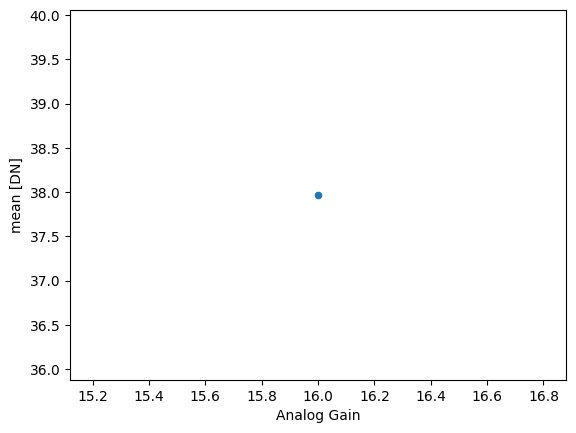

In [10]:
im_data.plot(kind = 'scatter', x = 'Analog Gain', y = 'mean [DN]')

program the otp

    def write_otp(self, address: int, value: int) -> None:
        seq = NameBasedProgrammingSequence()
        seq.add_instruction('OTP_COMMAND_MASTER', 2)
        seq.add_instruction('OTP_ADDR_MASTER', address)
        seq.add_instruction('OTP_DIN_MASTER', value)
        seq.add_instruction('OTP_START_MASTER', 1)
        seq.add_instruction('OTP_START_MASTER', 0)
        self.upload_programming_sequence(seq)

    def read_otp(self, address: int) -> int:
        seq = NameBasedProgrammingSequence()
        seq.add_instruction('OTP_COMMAND_MASTER', 0)
        seq.add_instruction('OTP_ADDR_MASTER', address)
        seq.add_instruction('OTP_START_MASTER', 1)
        seq.add_instruction('OTP_START_MASTER', 0)
        self.upload_programming_sequence(seq)
        otp_busy = 1
        while otp_busy:
            otp_busy = self.read_register('OTP_BUSY_MASTER')
        return self.read_register('OTP_DOUT_MASTER')

In [63]:
class AddressField(NamedTuple):
    addr: int
    mask: int
    shift: int

    def get_value(self, value):
        """Take in a byte that was read from the OTP and mask + shift it."""
        return (value & self.mask) << self.shift

class Mira050():
    def __init__(self):
        pass
    def write(self,addr,val):
        ret = i2c.rwReg(addr=addr, value=val, rw=1, flag=0) # WRITE bank sel 1
        return ret
    def read(self,addr):
        ret = i2c.rwReg(addr=addr, value=0, rw=0, flag=0) # WRITE bank sel 1
        return ret        
    def _set_data_to_otp(self, reg,value) -> int:
        
        """
        placeholder for otp readout
        https://forge.ams.com/svn/repos/mira_xs_doc/trunk/engineering/Test%20Specification/51193_OTP_Register_Map.xlsx
        
        """
        #check if empty
        self.BYTES_PER_ADDR=4
        addr_field =  AddressField(reg, 0xFFFFFFFF, 0)
        ret=self._get_data_from_otp(addr_field)
        print(f'data in otp is {ret}')
        if ret!=0xFFFFFFFF:
            print(f'data in otp is present. abort.')
            raise ValueError('otp is already set')
        
        self.write(0xe000,0)
        self.write(0x0066,0x2)
        self.write(0x0067,reg)        
        split_value = lambda x, y: x >> (8*y) & 255
        self.write(0x0068, split_value(value, 3))
        self.write(0x0069, split_value(value, 2))
        self.write(0x006A, split_value(value, 1))
        self.write(0x006B, split_value(value, 0))

        self.write(0x0064,0x1)
        time.sleep(0.1)
        self.write(0x0064,0x0)
        time.sleep(0.1)
        poll_cnt = 0
        busy_status = 1 
        while poll_cnt < 10 and busy_status==1:
            poll_cnt +=1
            print(poll_cnt)
            time.sleep(0.01)
            busy_status=self.read(0x0065)
        if busy_status==1:
            raise ValueError('cant set otp data')
        else:
            print('PROGRAMMING SUCCESSFULL')
        return busy_status
        

    
    def _get_data_from_otp(self, addr_field: AddressField) -> int:
        
        """
        placeholder for otp readout
        https://forge.ams.com/svn/repos/mira_xs_doc/trunk/engineering/Test%20Specification/51193_OTP_Register_Map.xlsx
        
        """
        reg = addr_field.addr
    
        self.write(0xe000,0)
        self.write(0x0066,0x0)
        self.write(0x0067,reg)
        
        self.write(0x0064,0x1)
        time.sleep(0.1)
        self.write(0x0064,0x0)
        time.sleep(0.1)
        poll_cnt = 0
        busy_status = 1 
        while poll_cnt < 10 and busy_status==1:
            poll_cnt +=1
            print(poll_cnt)
            time.sleep(0.01)
            busy_status=self.read(0x0065)
        if busy_status==1:
            raise ValueError('cant get otp data')
        
        self.write(0xe000,0)

        b3=self.read(0x006C)
        b2=self.read(0x006D)
        b1=self.read(0x006E)
        b0=self.read(0x006F)
        val=(b3<<24)+(b2<<16)+(b1<<8)+b0
    
        print(f'OTP data reg {reg}: {bin(val)}')
    
        return addr_field.get_value(val)
        
    def get_wafer_id(self) -> str:
        """Get the die's wafer ID (i.e. find out to which wafer this sample
        belonged). The ID is returned as a string."""
        addr_fields = (
            AddressField(0x11, 0xFFFFFFFF, 0),
            AddressField(0x12, 0xFFFFFFFF, 0),
            AddressField(0x13, 0xFFFFFFFF, 0),
            AddressField(0x14, 0xFFFFFFFF, 0),
        )
        self.BYTES_PER_ADDR=4
        bytes_arr = b''
        for addr_field in addr_fields:
            otp_data = self._get_data_from_otp(addr_field)
            bytes_arr += otp_data.to_bytes(
                self.BYTES_PER_ADDR,
                byteorder='little'
            )
        # Character "ETX" (0x03) indicates the end of the wafer ID string
        wafer_id_bytes = bytes_arr.split(b'\x03')[0]
        return wafer_id_bytes.decode('utf-8')
    
    
    def get_black_level_wafer(self) -> int:
        """OTP BLACK LEVEL."""
        # result = self._get_data_from_otp(AddressField(0x19, 0x0000FFFF, 0))
        self.BYTES_PER_ADDR=4
        addr_fields = (
            AddressField(0x01, 0x00000FFFF, 0),
        )
        bytes_arr = b''
        for addr_field in addr_fields:
            otp_data = self._get_data_from_otp(addr_field)
            bytes_arr += otp_data.to_bytes(
                self.BYTES_PER_ADDR,
                byteorder='little'
            )
    
        # Character "ETX" (0x03) indicates the end of the wafer ID string
        wafer_id_bytes = bytes_arr.split(b'\x03')[0]
        print(f'id bytes: {(wafer_id_bytes)}')
       
        return  int.from_bytes(wafer_id_bytes, byteorder='little', signed=False)
        
    def get_black_level_wafer_fine(self) -> int:
        """OTP BLACK LEVEL."""
        # result = self._get_data_from_otp(AddressField(0x19, 0x0000FFFF, 0))
        self.BYTES_PER_ADDR=4
        addr_fields = (
            AddressField(0x04, 0x00000FFFF, 0),
        )
        bytes_arr = b''
        for addr_field in addr_fields:
            otp_data = self._get_data_from_otp(addr_field)
            bytes_arr += otp_data.to_bytes(
                self.BYTES_PER_ADDR,
                byteorder='little'
            )
    
        # Character "ETX" (0x03) indicates the end of the wafer ID string
        wafer_id_bytes = bytes_arr.split(b'\x03')[0]
        print(f'id bytes: {(wafer_id_bytes)}')
       
        return  int.from_bytes(wafer_id_bytes, byteorder='little', signed=False)

#get_black_level_calibration_value_from_otp()
with Picamera2() as picam2:
    picam2.start()
    mira = Mira050()
    time.sleep(1)
    print(mira.get_wafer_id())
    print(mira.get_black_level_wafer())
    print(mira.get_black_level_wafer_fine())
    print(mira._set_data_to_otp(4,a))
    print(mira.get_black_level_wafer_fine())


[1:50:08.390751514] [1715]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[1:50:08.403180070] [5828]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[1:50:08.404354426] [5828]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media2
[1:50:08.413085136] [1715]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888
[1:50:08.413483706] [5828]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira050@36 - Selected sensor format: 576x768-SGRBG12_1X12 - Selected unicam format: 576x768-pgCC


1
OTP data reg 17: 0b111001010011010011100001010000
1
OTP data reg 18: 0b110001001011010011011100110011
1
OTP data reg 19: 0b11001101100100011000110010
1
OTP data reg 20: 0b11111111111111111111111111111111
P8M937-12F6
1
OTP data reg 1: 0b11111111111111110000100011000000
id bytes: b'\xc0\x08\x00\x00'
2240
1
OTP data reg 4: 0b100101
id bytes: b'%\x00\x00\x00'
37
1
OTP data reg 4: 0b100101
data in otp is 37
data in otp is present. abort.


ValueError: otp is already set